In [3]:
import json
import glob
import matplotlib.pylab as plt
import numpy as np
from scipy.special import erf
import sys
sys.path.append('./../../Figures/')
from fig_helper_functions import reflected_kde_1d
from matplotlib import style
style.use('./../../Figures/plotting.mplstyle')

# Notebook to plot KL divergences between original and reweighted individual event spin posteriors

First load the dicts that have the original vs. reweighted samples

In [4]:
# For loading files
models = ['betaPlusGaussian', 'betaPlusDoubleGaussian']
pops = ['3']
nevents = ['70'] 
date = '070523'

# Make Dict
data_dict = {}

# Cycle through the different models, populations, and no. of events
for model in models:
    data_model = {}
    for pop in pops: 
        data_pop = {}
        for nevent in nevents: 

            name = f"{date}_{model}_{pop}_{nevent}events_reweighted_sampleDict"

            with open(f'{model}/{name}.json', 'r') as f:
                data = json.load(f)

            data_pop[nevent+' events'] = data    

        data_model['pop '+pop] = data_pop
          
    data_dict[model] = data_model

In [5]:
# Parameters to cycle through and their associated bounds
params = ['chi1', 'chi2', 'cost1', 'cost2']
bounds = [(0,1), (0,1), (-1,1), (-1,1)]

Calculate the KL divergences

In [6]:
def KLdiv(x, y, bounds=None): 
    
    # get bounds of data
    if bounds is None:
        A = min(np.concatenate([x,y]))
        B = max(np.concatenate([x,y]))
    else: 
        A, B = bounds
            
    # calculate pdfs
    grid, p = reflected_kde_1d(x, A, B)
    _, q = reflected_kde_1d(y, A, B)
    
    dx = grid[1] - grid[0]
    
    # calculate KL divergence
    KL = np.sum(np.where((p!=0) & (q!=0), p * np.log(p/q), 0))*dx
    
    return KL

In [7]:
kl_dict = {}

# Cycle through models, events, and params
for model in models: 
            
    data = data_dict[model]['pop 3']['70 events']
    kl_dict_i = {}

    for event in data.keys():

        kl_dict_event = {}

        for param, b in zip(params, bounds): 
                        
            # Original vs. rw posteriores
            original_posterior = np.asarray(data[event]['original'][param])
            rw_posterior = np.asarray(data[event]['reweighted'][param])

            # Calculate KL divergence
            KLd = KLdiv(original_posterior, rw_posterior, bounds=b)

            kl_dict_event[param] = KLd
        kl_dict_i[event] = kl_dict_event
    kl_dict[model] = kl_dict_i

Plot the results

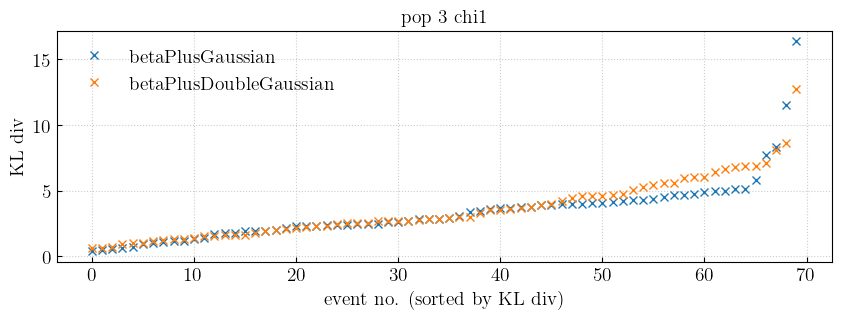

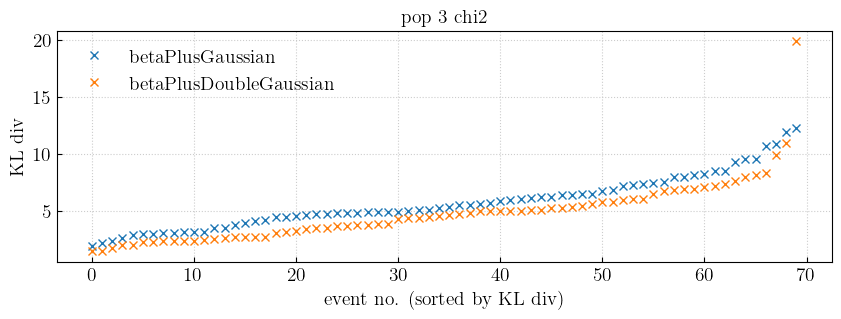

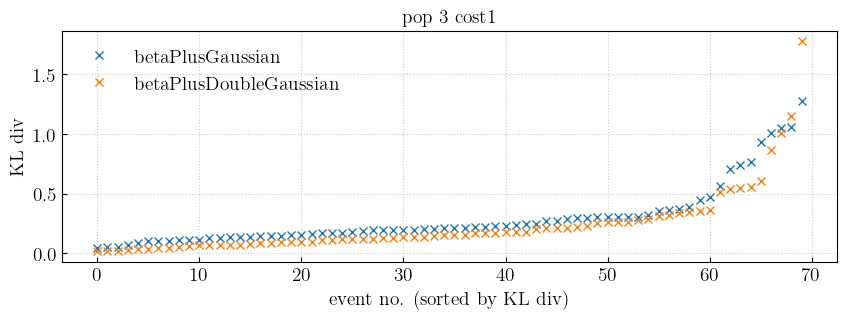

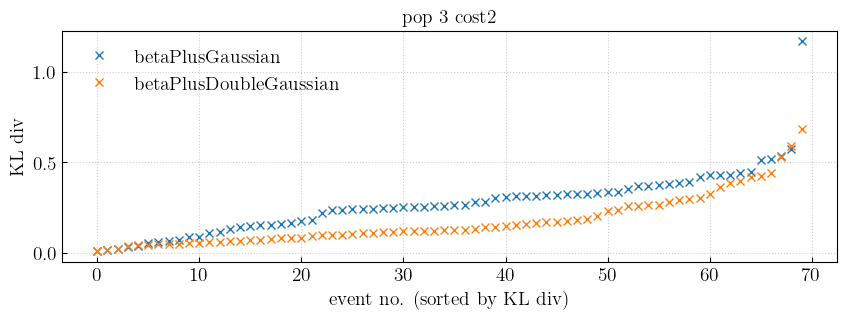

In [23]:
for param in params:

    plt.figure(figsize=(10,3))

    for model in models:  

        kl_divs_list = np.sort([kl_dict[model][x][param] for x in kl_dict[model].keys()])

        plt.plot(kl_divs_list, 'x', label=model)

    plt.legend()
    plt.grid(ls=':', color='silver', alpha=0.8)
    plt.ylabel('KL div', fontsize=14)
    plt.xlabel('event no. (sorted by KL div)', fontsize=14)
    plt.title('pop 3 ' + param, fontsize=14)
    plt.show()

Plot the results as a histogram

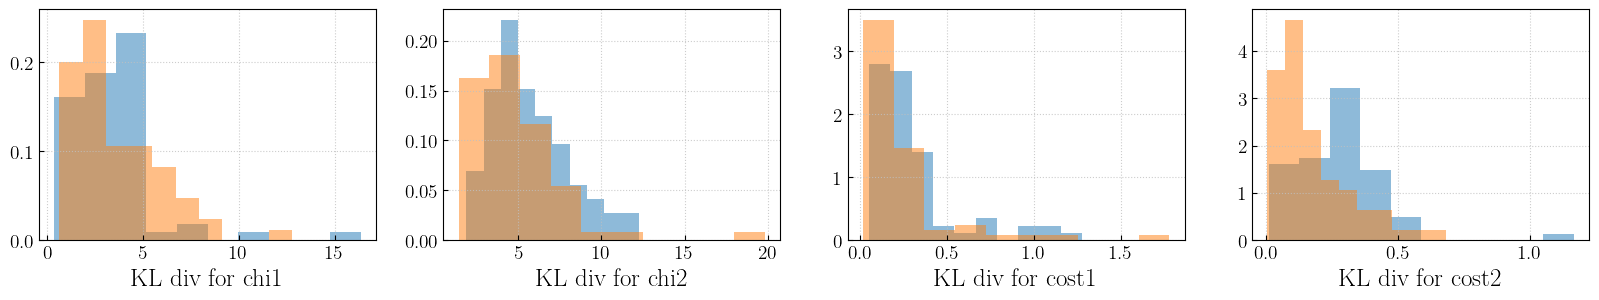

In [24]:
fig, axes = plt.subplots(1, 4, figsize=(20,3))

for i, param in enumerate(params):
    ax = axes[i]
    
    for model in models:  

        kl_divs_list = np.sort([kl_dict[model][x][param] for x in kl_dict[model].keys()])
        ax.hist(kl_divs_list, density=True, alpha=0.5, label=model)

    ax.grid(ls=':', color='silver', alpha=0.8)
    ax.set_xlabel(f'KL div for {param}')
    
plt.show()

## Same thing but with Hellinger Distance ($d_H$)

Calculate $d_H$

In [25]:
def dH(x, y, bounds=None): 
    
    # get bounds of data
    if bounds is None:
        A = min(np.concatenate([x,y]))
        B = max(np.concatenate([x,y]))
    else: 
        A, B = bounds
            
    # calculate pdfs
    grid, p = reflected_kde_1d(x, A, B)
    _, q = reflected_kde_1d(y, A, B)
    
    dx = grid[1] - grid[0]
    
    # calculate Hellinger distance
    d = 1 - np.sum(np.where((p!=0) & (q!=0), np.sqrt(p*q), 0))*dx
    
    return d

In [26]:
dH_dict = {}

# Cycle through models, events, and params
for model in models: 
            
    data = data_dict[model]['pop 3']['70 events']
    dH_dict_i = {}

    for event in data.keys():

        dH_dict_event = {}

        for param, b in zip(params, bounds): 
                        
            # Original vs. rw posteriores
            original_posterior = np.asarray(data[event]['original'][param])
            rw_posterior = np.asarray(data[event]['reweighted'][param])

            # Calculate KL divergence
            d = dH(original_posterior, rw_posterior, bounds=b)

            dH_dict_event[param] = d
        dH_dict_i[event] = dH_dict_event
    dH_dict[model] = dH_dict_i

Plot results

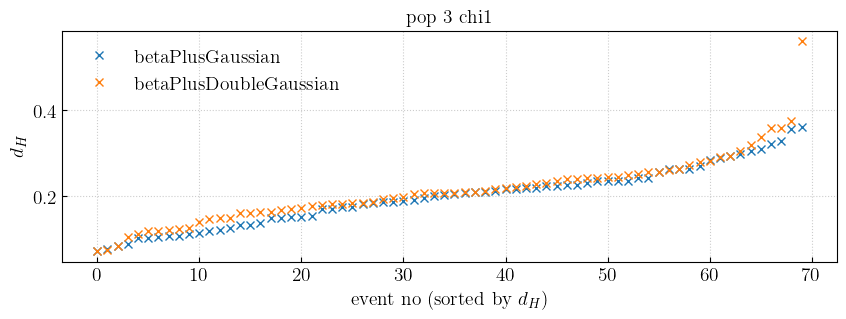

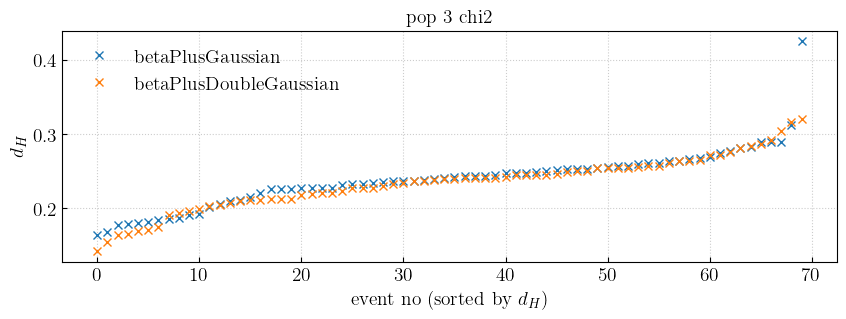

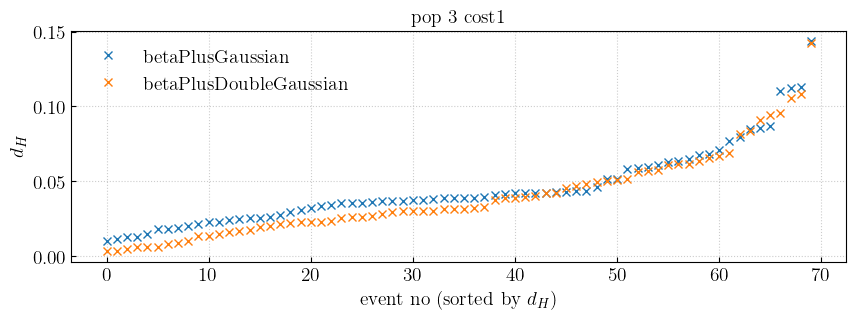

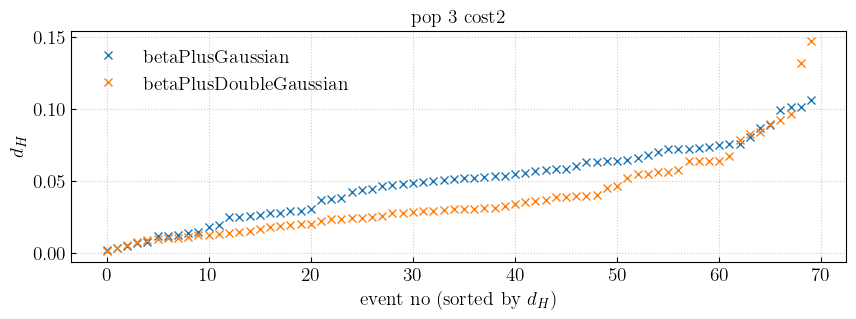

In [27]:
for param in params:

    plt.figure(figsize=(10,3))

    for model in models:  

        dHs_list = np.sort([dH_dict[model][x][param] for x in dH_dict[model].keys()])

        plt.plot(dHs_list, 'x', label=model)

    plt.legend()
    plt.grid(ls=':', color='silver', alpha=0.8)
    plt.ylabel(r'$d_H$', fontsize=14)   
    plt.xlabel('event no (sorted by $d_H$)', fontsize=14)
    plt.title('pop 3 ' + param, fontsize=14)
    plt.show()